In [22]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

In [4]:
#verinin okunması 
train_df = pd.read_csv("/kaggle/input/install-future-program-istanbul-hackathon/train.csv")
train_df['DATETIME'] = pd.to_datetime(train_df['DATETIME'], format='%Y-%m-%dT%H:%M')

In [5]:
#serverla göre df ' lerin ayrılması 
server_305 = train_df[train_df["SERVER"]=="CIHAZ_305"]
server_301 = train_df[train_df["SERVER"]=="CIHAZ_301"]

In [23]:
def prophet_anomali(cihaz_df):
    """
    Prophet modelinin yhat, y_upper, y_lower değerlerine göre oluşturulan bant aralığını df e ekler ve grafik üzerinde gösterir. 
    
    return: ilgili değişkenlerin eklendiği df i döndürür. 
    
    """
    
    #cpu ların ortalamasını alma
    df = cihaz_df.groupby(["DATETIME"]).agg({"CPULOAD":"mean"})
    
    #prophet modeline uygun formata getirme 
    df.index.names = ["ds"]
    df.reset_index(inplace=True)
    
    #time zone değerini zaman değişkeninden silme 
    df['ds'] = df['ds'].dt.tz_localize(None)
    df["y"] = df["CPULOAD"]
    df.drop("CPULOAD",axis = 1, inplace= True)
    print("check1")
    
    #model kurma 
    m = Prophet()
    m.fit(df)
    print("check3")
    
    #tahminleri yaptırma 
    y_pred = m.predict(df)

    #model sonuçlarını df e ekleme 
    df['Max_By_Prophet']=y_pred['yhat_upper']
    df['Min_By_Prophet']=y_pred['yhat_lower']
    
    
    #güven aralığınınn dışında kalan değerlere bir göz atma 
    #print('Max değere göre anomaliler \n', df[df['y']>df['Max_By_Prophet']][['ds','y','Min_By_Prophet','Max_By_Prophet']])
    #print('Min değere göre \n', df[df['y']<df['Min_By_Prophet']][['ds','y','Min_By_Prophet','Max_By_Prophet']])
    
    #grafiği çizdirme
    fig, ax = plt.subplots(figsize = (14,6))
    ax.fill_between(y_pred["ds"].tail(192), pred_upper.tail(192), pred_lower.tail(192), alpha=0.2)
    plt.plot(df["ds"].tail(192), df["y"].tail(192) , label='Gerçek Değerler')
    plt.plot(df["ds"].tail(192), y_pred["yhat"].tail(192), label='Tahmin Değerler')
    plt.xlabel("Tarih")
    plt.ylabel("CPULOAD")
    plt.legend()
    plt.show()
    print("check5")
    
    return df

check1


08:07:42 - cmdstanpy - INFO - Chain [1] start processing
08:07:43 - cmdstanpy - INFO - Chain [1] done processing


check3
check4


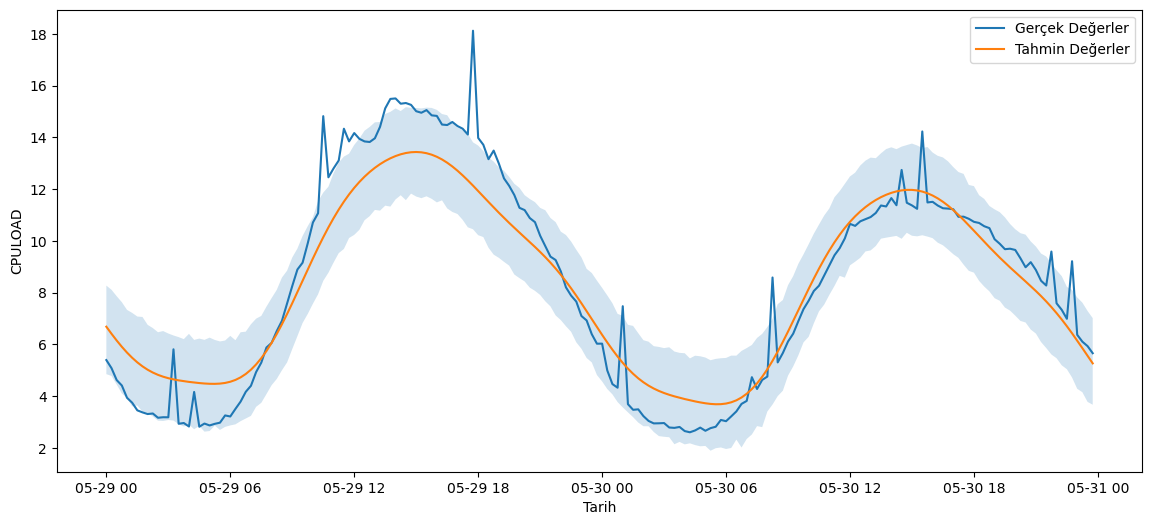

check5


In [7]:
df = prophet_anomali(server_301)

In [8]:
"""def calculate_rsi(df, window=12):
    # Pozitif değişim ve negatif değişim sütunlarını oluşturma
    df['Positive Change'] = df['y'].diff(1).clip(lower=0)
    df['Negative Change'] = -df['y'].diff(1).clip(upper=0)

    # ort yükseliş ve düşüş değerleri
    df['Average Gain'] = df['Positive Change'].rolling(window=window).mean()
    df['Average Loss'] = df['Negative Change'].rolling(window=window).mean()

    # İlk periyotta NaN değerlerini 0 ile doldurma
    df['Average Gain'].fillna(0, inplace=True)
    df['Average Loss'].fillna(0, inplace=True)

    # RS ve RSI
    df['RS'] = df['Average Gain'] / df['Average Loss']
    df['RSI'] = 100 - (100 / (1 + df['RS']))

    df.drop(['Positive Change', 'Negative Change', 'Average Gain', 'Average Loss', 'RS'], axis=1, inplace=True)

    return df """

"def calculate_rsi(df, window=12):\n    # Pozitif değişim ve negatif değişim sütunlarını oluşturma\n    df['Positive Change'] = df['y'].diff(1).clip(lower=0)\n    df['Negative Change'] = -df['y'].diff(1).clip(upper=0)\n\n    # ort yükseliş ve düşüş değerleri\n    df['Average Gain'] = df['Positive Change'].rolling(window=window).mean()\n    df['Average Loss'] = df['Negative Change'].rolling(window=window).mean()\n\n    # İlk periyotta NaN değerlerini 0 ile doldurma\n    df['Average Gain'].fillna(0, inplace=True)\n    df['Average Loss'].fillna(0, inplace=True)\n\n    # RS ve RSI\n    df['RS'] = df['Average Gain'] / df['Average Loss']\n    df['RSI'] = 100 - (100 / (1 + df['RS']))\n\n    df.drop(['Positive Change', 'Negative Change', 'Average Gain', 'Average Loss', 'RS'], axis=1, inplace=True)\n\n    return df "

In [24]:
def std_cal(df, std_number=2, tail_s=192):
    """
    bağımlı değişkenin standart sapmasını hesaplar, istenen çarpım değeriyle çarpım yapar ve güven aralığı oluşturur. 
    alt ve üst sınırları ilgili df e ekler ve döndürür 
    
    df  : işlem yapılacak dataframe 
    std_number: üst değer (std_max) ve alt değer (std_min) için ortalamaya kaç standart sapma ekleneceğini belirten parametre
    tail_s = grafik çizdirirken son kaç birim zamanın kullanacağını belirten parametre default 192 (2 gün)
    
    return: df std_max ve std_min değerleri eklenmiş dataframe 
    """
    df['std_min']=df['y'].mean() - std_number * df['y'].std()
    df['std_max']=df['y'].mean() + std_number * df['y'].std()
    
    fig, ax = plt.subplots(figsize = (14,6))
    ax.fill_between(df["ds"].tail(tail_s), df['std_max'].tail(tail_s), df['std_min'].tail(tail_s), alpha=0.1, color= 'red')
    plt.plot(df["ds"].tail(tail_s), df["y"].tail(tail_s) , label='Gerçek Değerler')
    #plt.plot(df["ds"].tail(tail_s), y_pred["yhat"].tail(tail_s), label='Tahmin Değerler')
    plt.xlabel("Tarih")
    plt.ylabel("CPULOAD")
    plt.legend()
    plt.show()
    
    return df

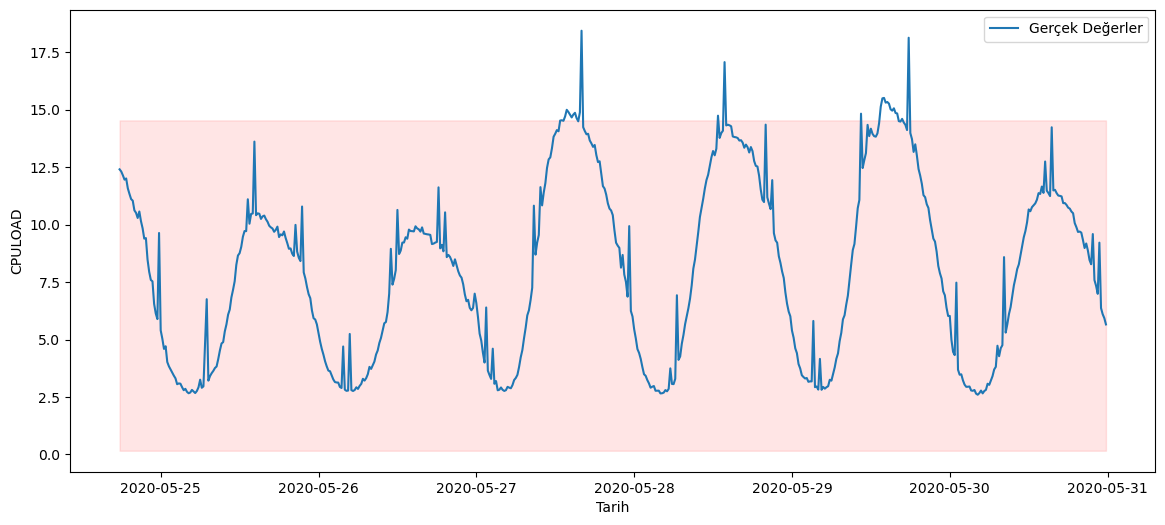

In [10]:
df = std_cal(df,tail_s=600)

In [11]:
def predict_SMA(df, window= 16,tail_s=192):
    """
    hareketli ortalama hesabı ile dinamik olarak değişen bir bant oluşturma ve güven aralığının alt üst limitlerini df e ekleme
    
    df: işlem yapılacak dataframe 
    window: hareketli ortalama hesabın uygulanacak gecikme değeri default 16 (4 saat)
    tail_s:  grafik çiziminde  görüntülenecek birim zaman default 192
    
    """
    #girilen gecikme sayısı ile hareketli ortalama hesabı 
    df["sma"] = df['y'].rolling(window=window).mean()
    rstd = df['y'].rolling(window=window).std()
    #hareketli ortalamanın 2 standart sapma alt ve üst değerleriyle bant oluşturulması 
    df["sma_up"] =  df["sma"] + 2 * rstd
    df["sma_down"] =  df["sma"] - 2 * rstd
    
    #gerçek değerlerin ve oluşturulan güven aralığının görselleştirilmesi 
    fig, ax = plt.subplots(figsize = (12,6))
    ax.fill_between(df["ds"].tail(tail_s), df["sma_up"].tail(tail_s), df["sma_down"].tail(tail_s), alpha=0.3, label='Sma_Opt_aralık',color = 'red')
    plt.plot(df["ds"].tail(tail_s), df["y"].tail(tail_s), label='Gerçek değer')
    
    plt.suptitle("Deneme")
    plt.xlabel("Tarih")
    plt.ylabel("Değer")
    plt.legend()

    return df

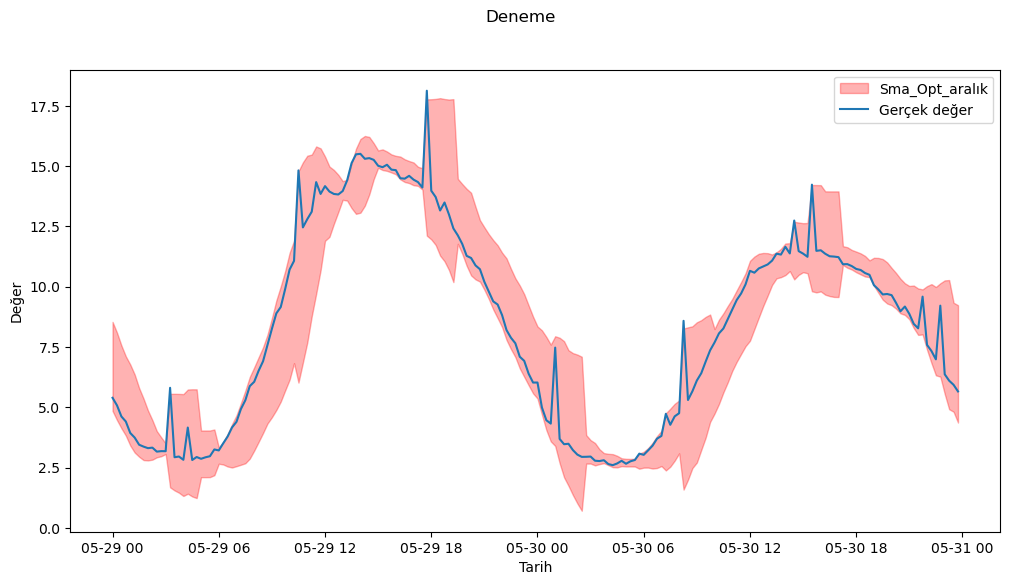

In [12]:
df = predict_SMA(df)

In [13]:
#farklı yöntemlerle oluşturulan güven aralıklarına göre anomali olarak değerlendirilecek değerlerin kategorik değişken olarak eklenmesi 
df['Std_Anomali'] = (df['y'] > df['std_max']) | (df['y'] < df['std_min'])
df['Sma_Anomali'] = (df['y'] > df['sma_up']) | (df['y'] < df['sma_down'])
df['Prophet_Anomali'] = (df['y'] > df['Max_By_Prophet']) | (df['y'] < df['Min_By_Prophet'])

In [14]:
print(df['Std_Anomali'].value_counts())
print(df['Sma_Anomali'].value_counts())
print(df["Prophet_Anomali"].value_counts())

False    6413
True      102
Name: Std_Anomali, dtype: int64
False    6292
True      223
Name: Sma_Anomali, dtype: int64
False    5585
True      930
Name: Prophet_Anomali, dtype: int64


In [15]:
def anomaly_plot(df,an_column_name,tail_size=192):
    """
    anomali olarka belirlenen değerlerin grafikte daha net görünmesi için dikey çizgierle gözlemlenmesi 
    
    df : işlem yapılmak istenen dataframe in parametre olarak verilmesi 
    an_column_name: anomali olup olmadığını belirten sütun isminin verilmesi, 
    (anomali tespiti farklı yöntemlerle yapılmaya çalışıldığı için sütun isimleri farklı)
    tail_size: grafiği çizdirilecek birim zaman default 192
    
    
    """
    df = df[-tail_size:]
    plt.figure(figsize=(10, 6))

    #tüm veriyi çizdirme
    plt.plot(df['ds'], df['y'], 'b-')

    #anomali için düşey çizgiler
    anomali_dates = df[df[an_column_name] == True]['ds']
    for date in anomali_dates:
        plt.plot([date, date], [df['y'].min(), df['y'].max()], color='green', alpha=0.2)

    plt.xlabel('Date')
    plt.ylabel('y')
    plt.title('Anomaly Detection')

    plt.legend()
    plt.show()
    

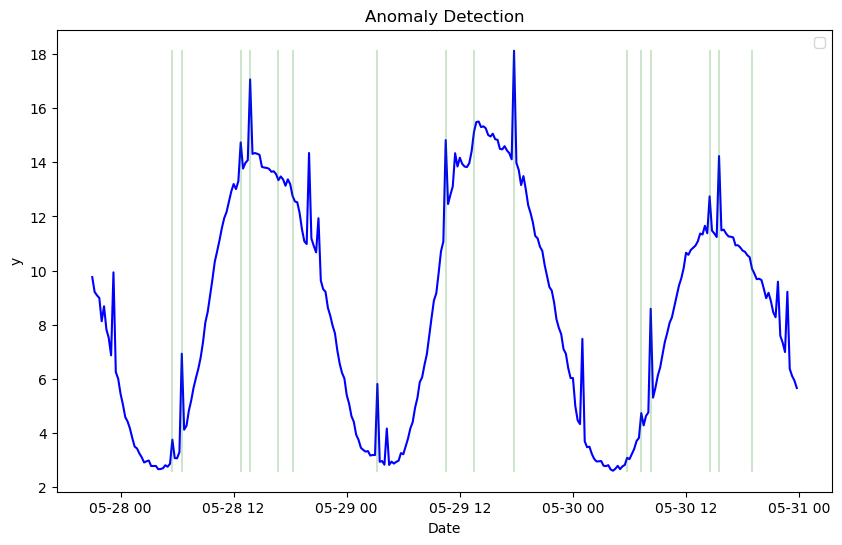

In [121]:
anomaly_plot(df,an_column_name='Sma_Anomali',tail_size=300)

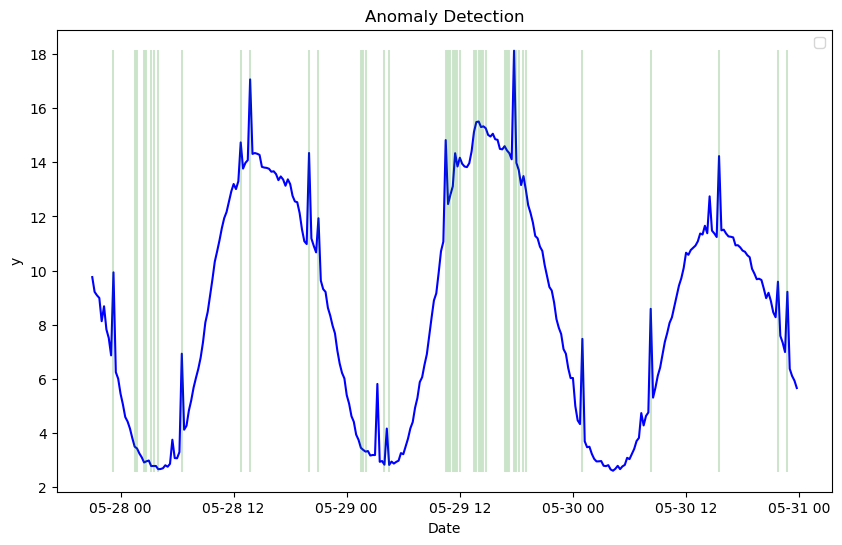

In [17]:
anomaly_plot(df,an_column_name='Prophet_Anomali',tail_size=300)

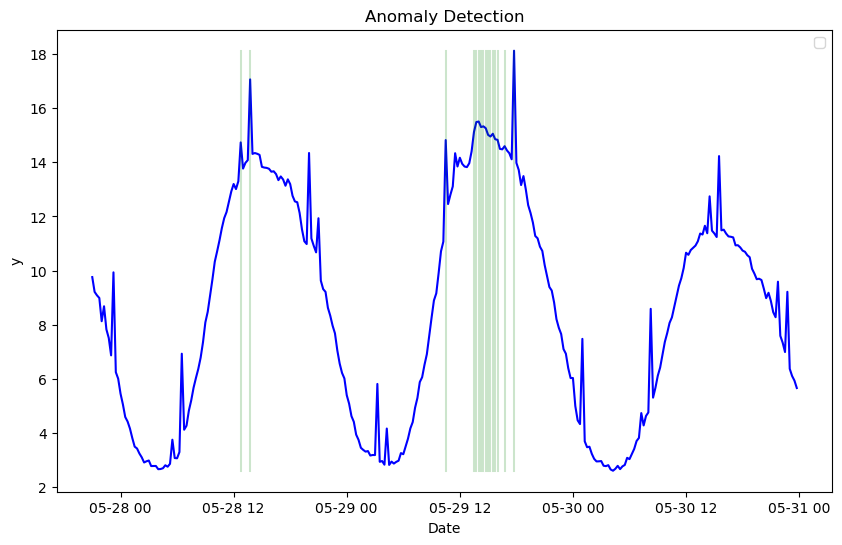

In [19]:
anomaly_plot(df,an_column_name='Std_Anomali',tail_size=300)

In [20]:
filtered_df = df[(df['Prophet_Anomali'] == True) & (df['Sma_Anomali'] == True)& (df['Std_Anomali'] == True)]

In [27]:
filtered_df.head(10)

,ds,y,Max_By_Prophet,Min_By_Prophet,std_min,std_max,sma,sma_up,sma_down,Std_Anomali,Sma_Anomali,Prophet_Anomali
50,2020-03-24 12:30:00,14.789583,12.712786,9.396784,0.162856,14.531184,11.710298,14.633249,8.787346,True,True,True
249,2020-03-26 14:15:00,15.095000,13.700555,10.297591,0.162856,14.531184,12.701190,14.895274,10.507107,True,True,True
820,2020-04-01 14:15:00,15.050833,13.904718,10.521168,0.162856,14.531184,12.444167,14.819824,10.068509,True,True,True
1396,2020-04-07 14:15:00,15.868333,13.535483,9.942399,0.162856,14.531184,13.564583,15.782086,11.347081,True,True,True
1597,2020-04-09 17:00:00,14.879583,12.989727,9.742989,0.162856,14.531184,12.139167,14.585469,9.692864,True,True,True
1683,2020-04-10 14:45:00,16.198333,13.658009,10.266865,0.162856,14.531184,12.910952,15.896669,9.925236,True,True,True
1712,2020-04-10 22:00:00,19.978333,9.051352,5.657776,0.162856,14.531184,10.237440,19.678942,0.795939,True,True,True
1969,2020-04-13 14:15:00,14.663750,13.357657,9.954256,0.162856,14.531184,12.574762,14.504466,10.645058,True,True,True
2172,2020-04-15 17:00:00,15.539583,13.190374,9.854883,0.162856,14.531184,12.348393,15.205091,9.491695,True,True,True
2259,2020-04-16 14:45:00,15.413333,13.588128,10.183502,0.162856,14.531184,12.628929,15.251159,10.006698,True,True,True
